# CLEANING AND PRE-PROCESSING DATA

Studi kasus ini merupakan Capstone Project Modul 2 Job Connector Data Scientist and Machine Learning dari Purwadhika Digital Technology School.

Pemilik : Gian Habli Maulana

Tanggal : 25 Juni 2024 - 10 Juli 2024

## Study Case: New York City TLC Trip Record

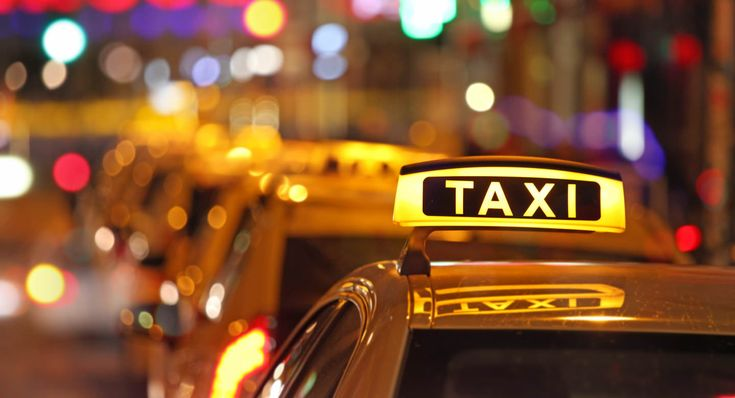

## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

color = sns.color_palette("Paired")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 2. Load Dataset

### Main Dataset

**Referensi** : https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

**Desription Features**

| Features                  | Description                                                                                                                   |
|---------------------------|-------------------------------------------------------------------------------------------------------------------------------|
|``VendorID``               | Kode ID yang menunjukkan vendor taksi.                                                                                        |
|                           | 1 = Creative Mobile Technologies, LLC                                                                                         |
|                           | 2 = VeriFone Inc.                                                                                                             |   
|``lpep_pickup_datetime``   | Tanggal dan waktu saat perjalanan taksi dimulai.                                                                              |
|``lpep_dropoff_datetime``  | Tanggal dan waktu saat perjalanan taksi berakhir.                                                                             |
|``store_and_fwd_flag``     | Menunjukkan apakah catatan perjalanan disimpan dalam memori kendaraan sebelum dikirim ke vendor. Y berarti "simpan dan lanjutkan", N berarti bukan perjalanan "simpan dan lanjutkan".                                                                                                                    |
|``RatecodeID``             | Kode tarif untuk perjalanan.                                                                                                  |
|                           |1 = Tarif standar                                                                                                              |
|                           |2 = JFK                                                                                                                        |
|                           |3 = Newark                                                                                                                     |
|                           |4 = Nassau atau Westchester                                                                                                    |
|                           |5 = Tarif yang dinegosiasikan                                                                                                  |
|                           |6 = Perjalanan kelompok.                                                                                                       |
|``PULocationID``           | ID lokasi penjemputan, yang sesuai dengan zona taksi di mana meteran (taximeter) diaktifkan.                                  |
|``DOLocationID``           | ID lokasi penurunan, yang sesuai dengan zona taksi di mana meteran (taximeter) dinonaktifkan.                                 |
|``passenger_count``        | Jumlah penumpang di dalam kendaraan.                                                                                          |
|``trip_distance``          | Jarak perjalanan dalam mil.                                                                                                   |
|``fare_amount``            | Tarif yang diukur untuk perjalanan.                                                                                           |
|``extra``                  | Biaya tambahan. Saat ini, ini hanya mencakup biaya tambahan 0,5 dolar dan 1 dolar untuk jam sibuk dan larut malam.            |
|``mta_tax``                | Pajak MTA sebesar 0,50 dolar yang otomatis aktif berdasarkan tarif yang diukur yang digunakan.                                |
|``tip_amount``             | Jumlah tip. Bidang ini otomatis diisi untuk tip kartu kredit. Tip tunai tidak termasuk.                                       |
|``tolls_amount``           | Jumlah total dari semua tol yang dibayar dalam perjalanan.                                                                    |
|``ehail_fee``              | Biaya tambahan sebesar 1 dolar yang otomatis dikenakan untuk setiap perjalanan yang dipesan melalui platform ehail.           |
|``improvement_surcharge``  | Biaya tambahan sebesar 0,30 dolar yang dinilai pada awal perjalanan. Biaya tambahan ini mulai dikenakan pada tahun 2015.      |
|``total_amount``           | Jumlah total yang dikenakan kepada penumpang. Bidang ini mencakup tarif yang diukur, biaya tambahan, mta_tax, tip_amount, dan tolls_amount ditambah biaya tambahan ehail atau improvement_surcharge.                                                                                                   |
|``payment_type``           | Kode numerik yang menunjukkan metode pembayaran.                                                                              |
|``trip_type``              | Kode yang menunjukkan apakah perjalanan adalah dari sisi jalan atau dari pengiriman yang otomatis ditetapkan berdasarkan tarif yang diukur yang digunakan tetapi dapat diubah oleh pengemudi.                                                                                                               |
|                           | 1 = Street-hail                                                                                                               |
|                           | 2 = Dispatch                                                                                                                  |
|``congestion_surcharge``   | Biaya kemacetan sebesar 2,75 dolar untuk perjalanan dengan taksi kuning dan hijau di Manhattan selatan dari 96th St. Biaya tambahan ini mulai dikenakan pada tahun 2019.                                                                                                                                  |

In [ ]:
#Load Dataset from csv file
trip = pd.read_csv('/content/drive/MyDrive/NYC TLC Trip Record.csv')

### Supporting Dataset

**Referensi** : https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Taxi Zone Shapefile (PARQUET)

**Desription Features**

| Features                  | Description                                                                                                                   |
|---------------------------|-------------------------------------------------------------------------------------------------------------------------------|
|``ObjectID``               | Kode ID yang menunjukkan Zona Area di New York City                    |   
|``LocationID``           | ID lokasi yang sesuai dengan zona taksi di mana meteran (taximeter) diaktifkan.                                  |
|``Shape_Leng``           | Total panjang keliling poligon.                                 |
|``Shape_Area``        | Total Area poligon.                                                                                          |
|``zone``          | Zona tertentu di New York City.                                                                                                   |
|``borough``            | Sektor-sektor yang ada di New York City.                                                                                           |
|``longitude``                  | Garis Lintang.            |
|``latitude``                | Garis Bujur.                                |
|

In [ ]:
#Function to process shapefile
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]

        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2

        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [ ]:
#Process Shapefile
sf = shapefile.Reader('/content/drive/MyDrive/taxi_zones.shp')
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [ ]:
#Load Dataset from shapefile
location = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")

### Copying Dataset

In [ ]:
df_trip = trip.copy()
df_trip.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00


In [ ]:
df_location = location.copy()
df_location.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


### Merging Dataset

In [ ]:
df = pd.merge(df_trip, df_location.add_prefix('PU'), left_on="PULocationID", right_on="PULocationID", how="left")
df = pd.merge(df, df_location.add_prefix('DO'), left_on="DOLocationID", right_on="DOLocationID", how="left")

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,PUborough,PUlongitude,PUlatitude,DOOBJECTID,DOShape_Leng,DOShape_Area,DOzone,DOborough,DOlongitude,DOlatitude
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,...,Manhattan,9.948789e+05,234246.399324,143.0,0.054180,0.000151,Lincoln Square West,Manhattan,9.874468e+05,221916.587874
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,...,Manhattan,9.937954e+05,231438.438453,43.0,0.099739,0.000380,Central Park,Manhattan,9.938216e+05,224339.434436
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,...,Queens,1.010330e+06,222885.452891,179.0,0.071381,0.000184,Old Astoria,Queens,1.004254e+06,220334.193347
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,...,Manhattan,9.978960e+05,232264.009901,238.0,0.060109,0.000185,Upper West Side North,Manhattan,9.917176e+05,227746.100420
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,...,Manhattan,9.978960e+05,232264.009901,74.0,0.110291,0.000295,East Harlem North,Manhattan,1.001579e+06,232789.873551


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69600 entries, 0 to 69599
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               69600 non-null  int64  
 1   lpep_pickup_datetime   69600 non-null  object 
 2   lpep_dropoff_datetime  69600 non-null  object 
 3   store_and_fwd_flag     65240 non-null  object 
 4   RatecodeID             65240 non-null  float64
 5   PULocationID           69600 non-null  int64  
 6   DOLocationID           69600 non-null  int64  
 7   passenger_count        65240 non-null  float64
 8   trip_distance          69600 non-null  float64
 9   fare_amount            69600 non-null  float64
 10  extra                  69600 non-null  float64
 11  mta_tax                69600 non-null  float64
 12  tip_amount             69600 non-null  float64
 13  tolls_amount           69600 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

## 3. Skimming Dataset

In [ ]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value(%)': df.isna().mean().values * 100,
    'negative_value(%)': [len(df[col][df[col] < 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    'duplicate' : df.duplicated().sum(),
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]}
).round(3)

,feature,data_type,null_value(%),negative_value(%),0_value(%),duplicate,n_unique,sample_unique
0,VendorID,int64,0.000,0.000,0.000,0,2,"[2, 1]"
1,lpep_pickup_datetime,object,0.000,0.000,0.000,0,66575,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
2,lpep_dropoff_datetime,object,0.000,0.000,0.000,0,66519,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 202..."
3,store_and_fwd_flag,object,6.264,0.000,0.000,0,2,"[N, Y, nan]"
4,RatecodeID,float64,6.264,0.000,0.000,0,6,"[1.0, 5.0, 4.0, 3.0, 2.0, 99.0, nan]"
5,PULocationID,int64,0.000,0.000,0.000,0,226,"[166, 24, 223, 41, 181, 255, 75, 66, 195, 83, ..."
6,DOLocationID,int64,0.000,0.000,0.000,0,249,"[143, 43, 179, 238, 74, 262, 45, 75, 166, 140,..."
7,passenger_count,float64,6.264,0.000,0.487,0,10,"[1.0, 2.0, 4.0, 3.0, 6.0, 5.0, 0.0, 7.0, 9.0, ..."
8,trip_distance,float64,0.000,0.000,5.003,0,1870,"[2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1..."
9,fare_amount,float64,0.000,0.253,0.124,0,2553,"[14.9, 10.7, 7.2, 6.5, 6.0, 17.7, 19.1, 14.2, ..."


## 4. Dropping Column

In [ ]:
df.drop(['VendorID',
         'store_and_fwd_flag',
         'ehail_fee',
         'passenger_count',
         'extra',
         'mta_tax',
         'tolls_amount',
         'improvement_surcharge',
         'congestion_surcharge',
         'PUOBJECTID',
         'PUShape_Leng',
         'PUShape_Area',
         'DOOBJECTID',
         'DOShape_Leng',
         'DOShape_Area',
         'PUlongitude',
         'PUlatitude',
         'DOlongitude',
         'DOlatitude'], axis=1, inplace=True)

In [ ]:
df.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough
0,2023-01-01 00:26:10,2023-01-01 00:37:11,1.0,166,143,2.58,14.9,4.03,24.18,1.0,1.0,Morningside Heights,Manhattan,Lincoln Square West,Manhattan
1,2023-01-01 00:51:03,2023-01-01 00:57:49,1.0,24,43,1.81,10.7,2.64,15.84,1.0,1.0,Bloomingdale,Manhattan,Central Park,Manhattan
2,2023-01-01 00:35:12,2023-01-01 00:41:32,1.0,223,179,0.00,7.2,1.94,11.64,1.0,1.0,Steinway,Queens,Old Astoria,Queens
3,2023-01-01 00:13:14,2023-01-01 00:19:03,1.0,41,238,1.30,6.5,1.70,10.20,1.0,1.0,Central Harlem,Manhattan,Upper West Side North,Manhattan
4,2023-01-01 00:33:04,2023-01-01 00:39:02,1.0,41,74,1.10,6.0,0.00,8.00,1.0,1.0,Central Harlem,Manhattan,East Harlem North,Manhattan


## 5. Data Understanding

### Data Distribution

In [ ]:
df[['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']].describe()

,trip_distance,fare_amount,tip_amount,total_amount
count,69600.000000,69600.000000,69600.000000,69600.000000
mean,7.995647,16.579162,2.112657,21.724434
std,579.238674,13.395914,3.040636,15.367387
min,0.000000,-70.000000,-10.500000,-71.500000
25%,1.110000,9.300000,0.000000,12.900000
50%,1.840000,13.500000,1.500000,17.805000
75%,3.200000,19.800000,3.280000,26.040000
max,120098.840000,490.000000,222.220000,491.000000


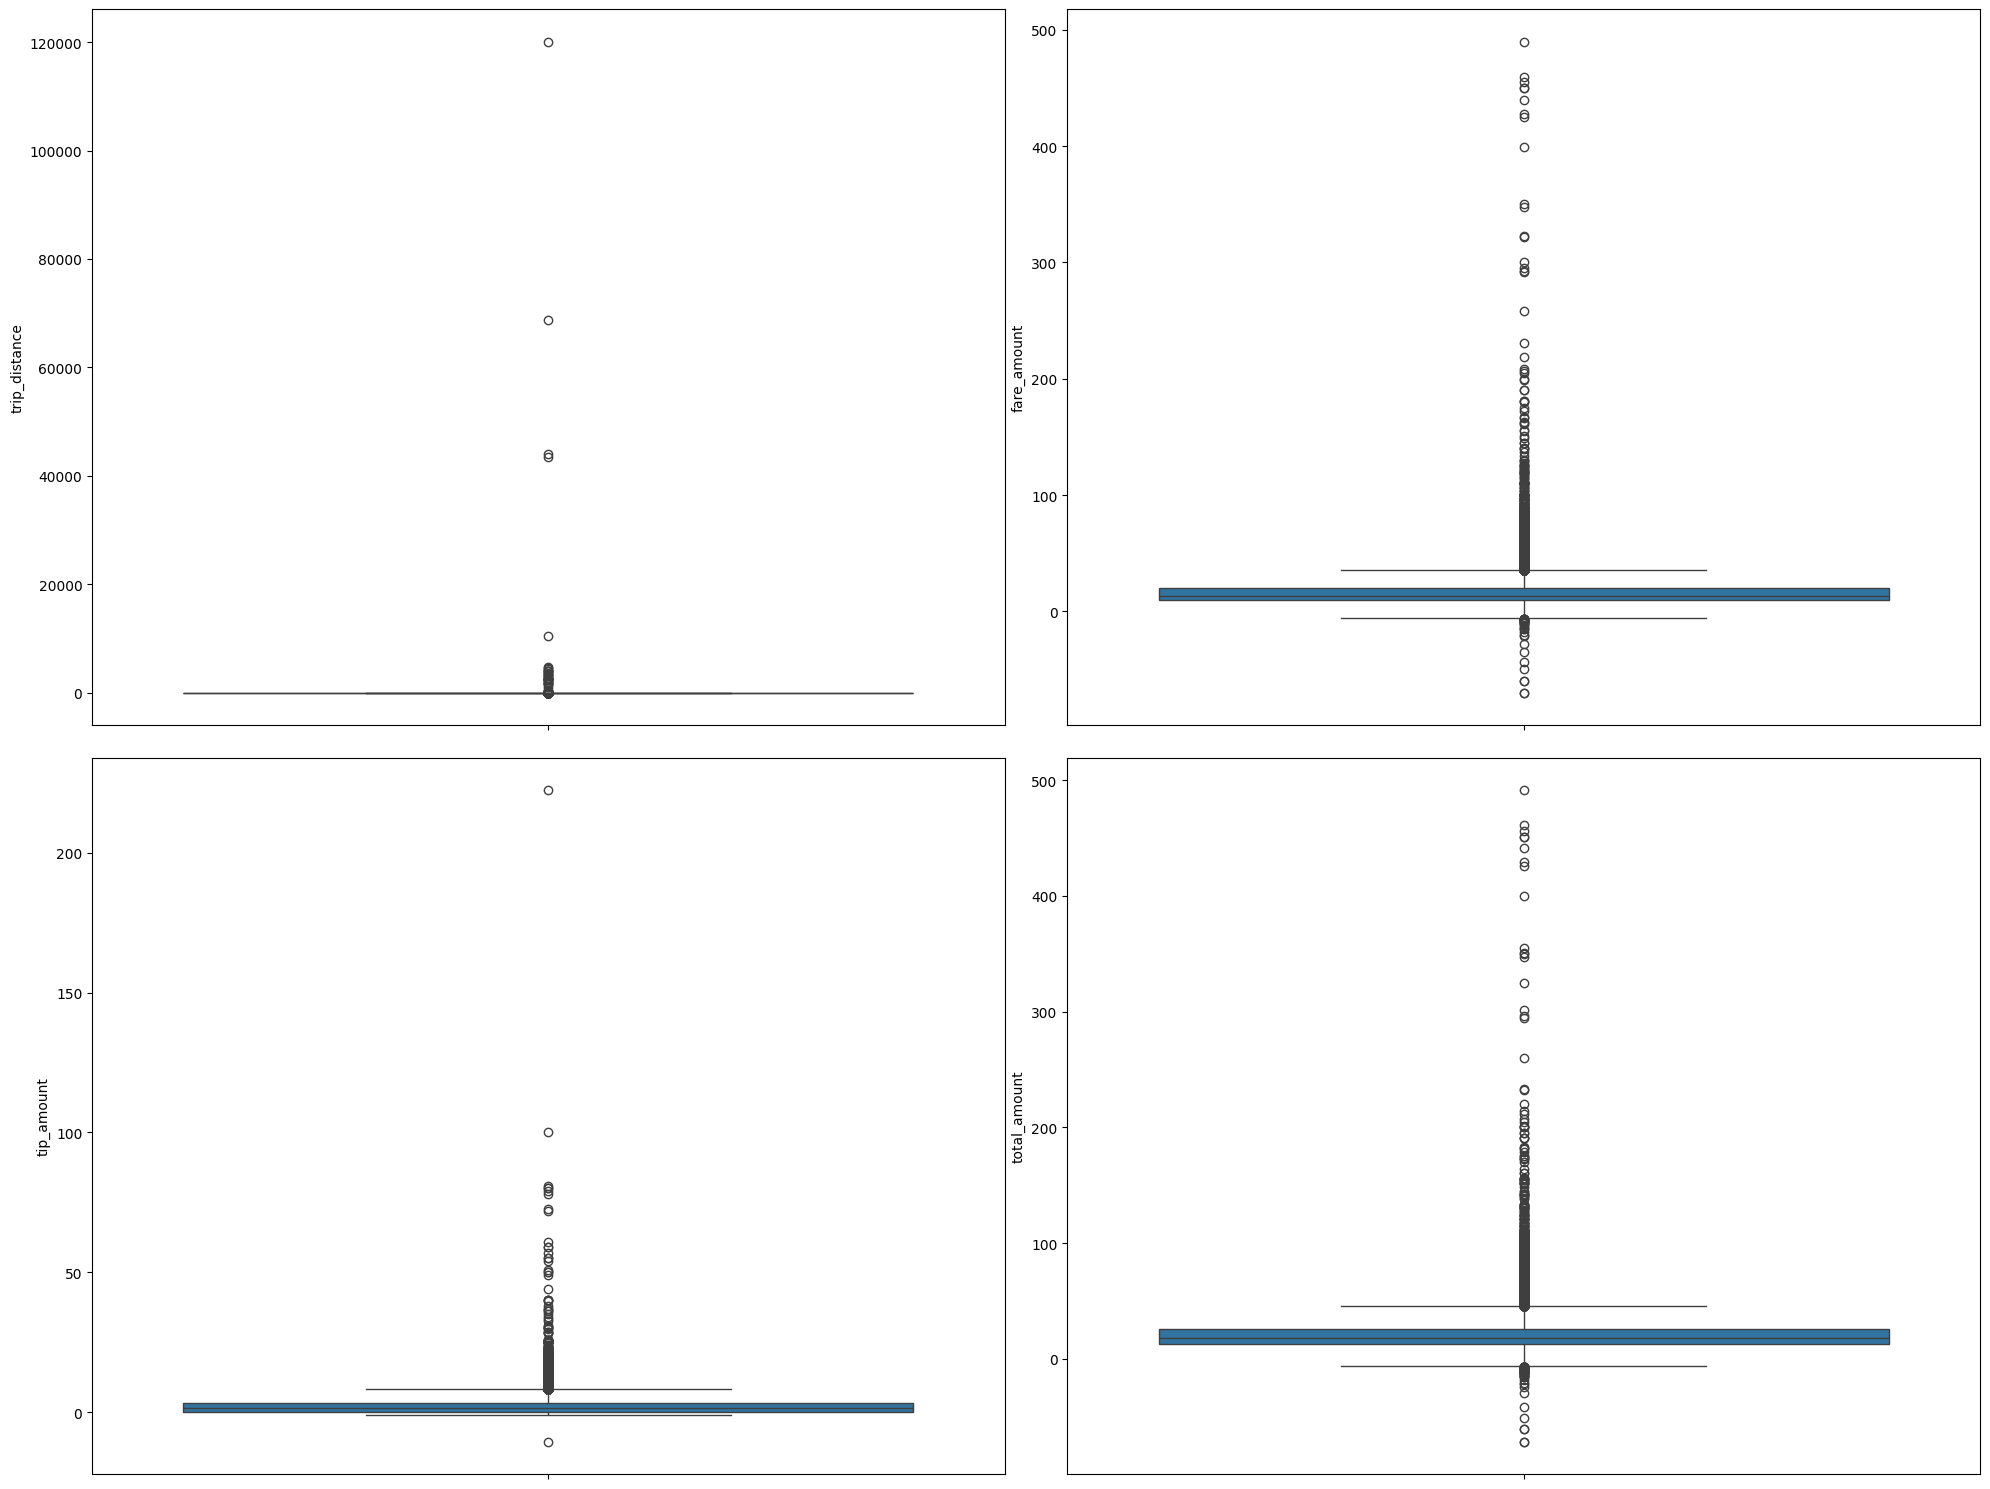

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,15))
index = 0
axs = axs.flatten()
for k, v in df[['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']].select_dtypes(include=[np.number]).items():
    sns.boxplot(y=k, data=df[['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']], ax=axs[index])
    index += 1
plt.tight_layout(w_pad=0.5, h_pad=2)

Berdasarkan boxplot di atas, dapat disimpulkan dataset terdapat banyak outliers dan tidak ada satupun yang terdistribusi normal.

### Checking Missing Values

<Axes: >

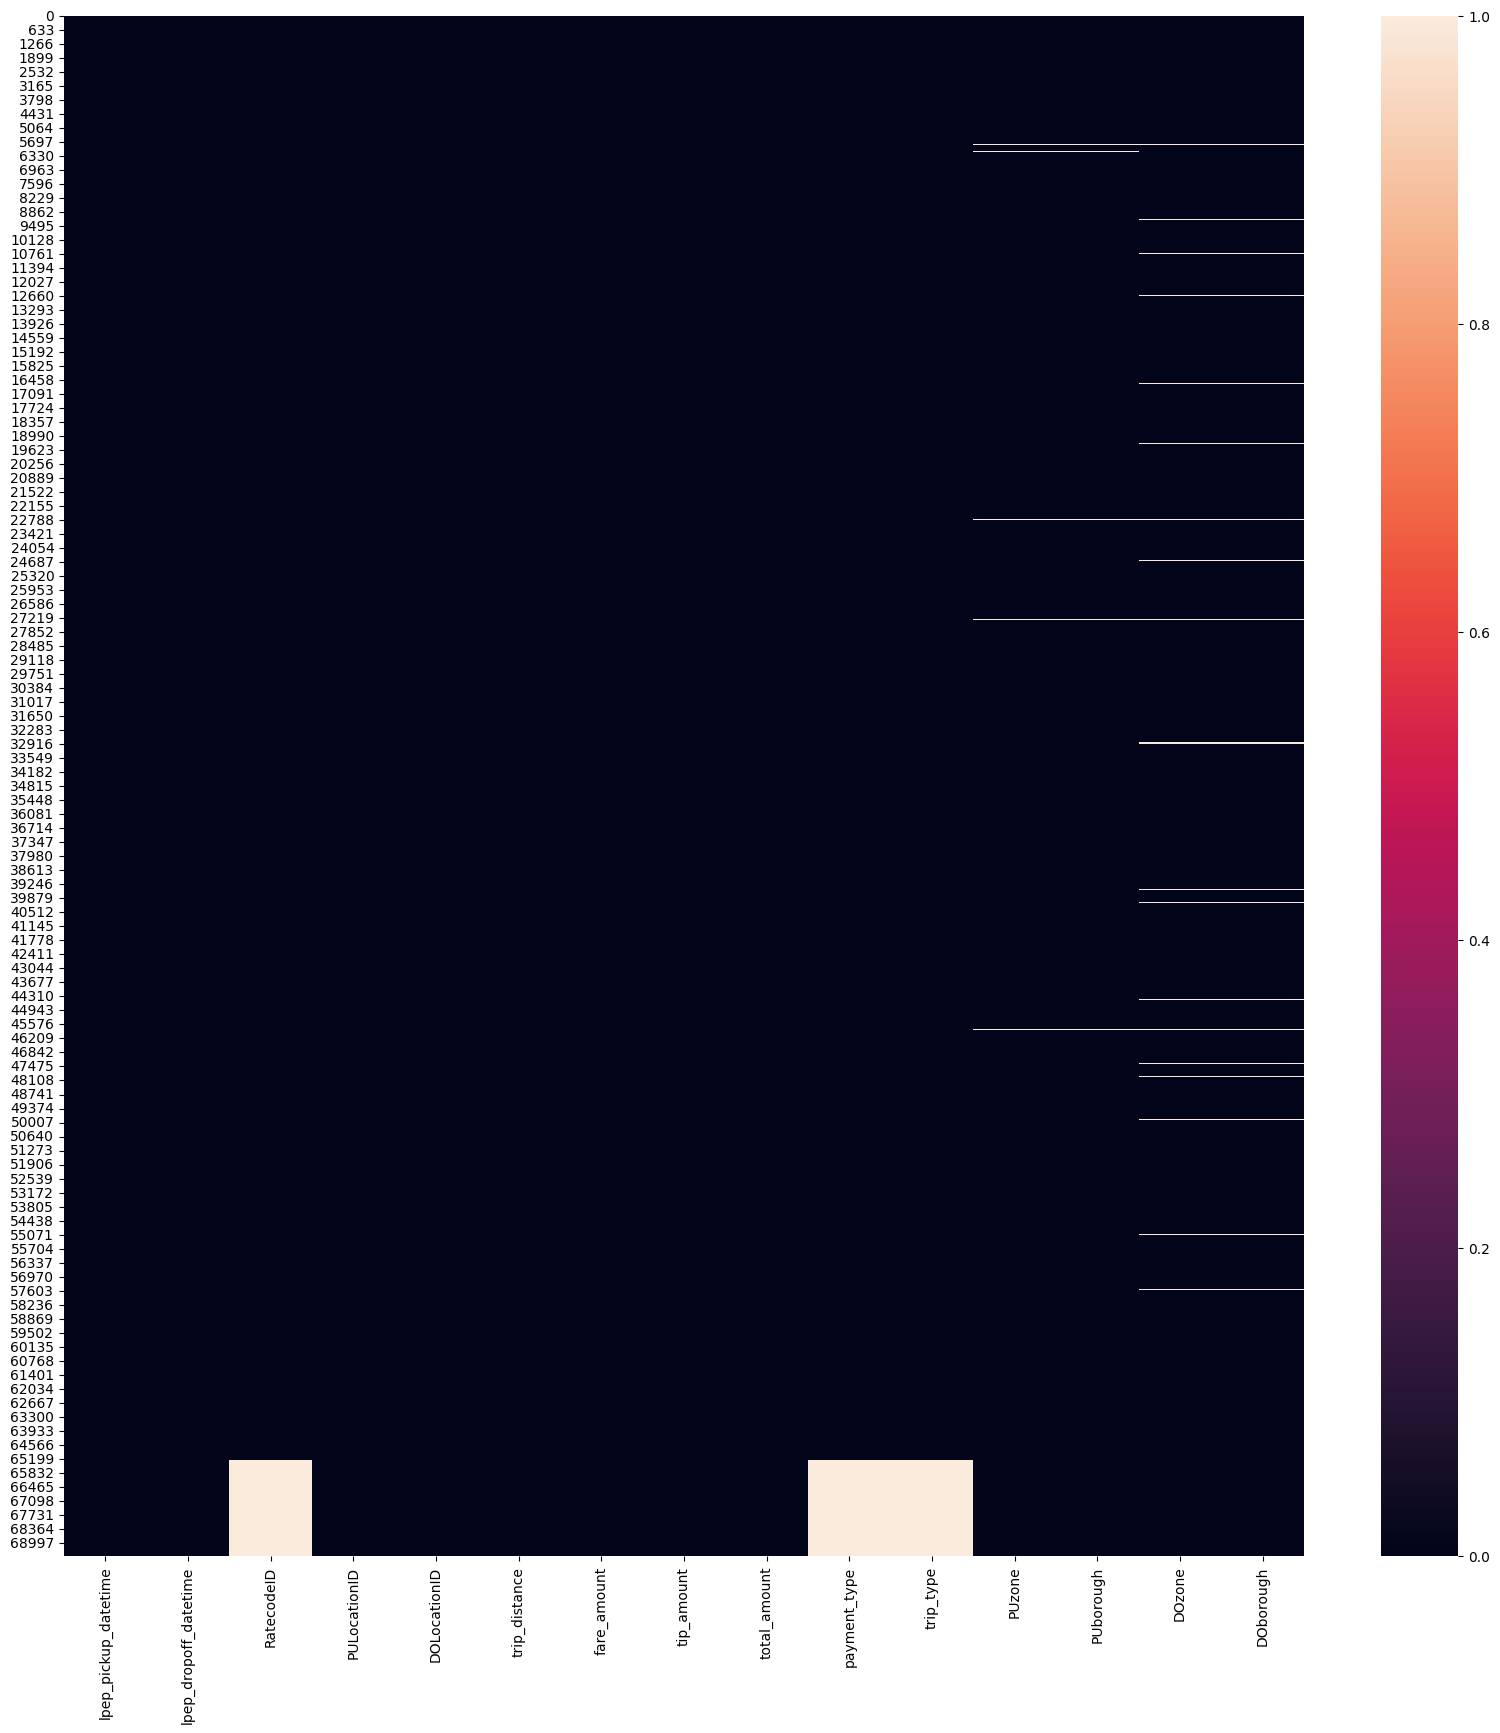

In [ ]:
# Distribution of Missing Value
plt.figure(figsize=(20,20))
sns.heatmap(df.isna())

## 6. Data Cleaning

### Duplicate Value Handling

In [ ]:
# Check Duplicate Value
df[df.duplicated()].head(6)

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough
163,2023-01-01 02:29:37,2023-01-01 02:53:27,1.0,223,56,4.38,24.0,0.0,26.5,2.0,1.0,Steinway,Queens,Corona,Queens
164,2023-01-01 02:29:37,2023-01-01 02:53:27,1.0,223,56,4.38,24.0,0.0,26.5,2.0,1.0,Steinway,Queens,Corona,Queens
165,2023-01-01 02:29:37,2023-01-01 02:53:27,1.0,223,56,4.38,24.0,0.0,26.5,2.0,1.0,Steinway,Queens,Corona,Queens
183,2023-01-01 02:43:52,2023-01-01 03:01:20,1.0,129,56,2.36,17.0,0.0,19.5,2.0,1.0,Jackson Heights,Queens,Corona,Queens
184,2023-01-01 02:43:52,2023-01-01 03:01:20,1.0,129,56,2.36,17.0,0.0,19.5,2.0,1.0,Jackson Heights,Queens,Corona,Queens
185,2023-01-01 02:43:52,2023-01-01 03:01:20,1.0,129,56,2.36,17.0,0.0,19.5,2.0,1.0,Jackson Heights,Queens,Corona,Queens


In [ ]:
# Check Number of Duplicate Value
len(df[df.duplicated()])

1389

Sebelum menghapus duplicate value, dilakukan cek ulang duplicate value secara subset berdasarkan beberapa fitur berikut:

1. lpep_pickup_datetime
2. lpep_dropoff_datetime
3. RatecodeID
4. trip_distance

Berdasarkan fitur-fitur tersebut, boleh jadi ada baris yang memiliki value sama tetapi nilainya berupa negatif.


In [ ]:
duplicate_value_subset = df[df.duplicated(subset=['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'RatecodeID', 'trip_distance'], keep=False)]

In [ ]:
duplicate_value_subset.tail(6)

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough
69055,2023-01-27 18:00:00,2023-01-27 18:18:00,NaN,56,226,6.20,19.29,4.18,24.47,NaN,NaN,Corona,Queens,Sunnyside,Queens
69056,2023-01-27 18:00:00,2023-01-27 18:18:00,NaN,56,226,6.20,19.29,4.18,24.47,NaN,NaN,Corona,Queens,Sunnyside,Queens
69468,2023-01-31 00:02:00,2023-01-31 00:13:00,NaN,56,130,5.19,20.44,4.29,25.73,NaN,NaN,Corona,Queens,Jamaica,Queens
69469,2023-01-31 00:02:00,2023-01-31 00:13:00,NaN,56,130,5.19,20.44,4.29,25.73,NaN,NaN,Corona,Queens,Jamaica,Queens
69470,2023-01-31 00:02:00,2023-01-31 00:13:00,NaN,56,130,5.19,20.44,4.29,25.73,NaN,NaN,Corona,Queens,Jamaica,Queens
69471,2023-01-31 00:02:00,2023-01-31 00:13:00,NaN,56,130,5.19,20.44,4.29,25.73,NaN,NaN,Corona,Queens,Jamaica,Queens


Jika memeriksa duplicate value berdasarkan subset(fitur-fitur) tersebut makadapat dilihat terdapat duplicate value dimana value pertama bernilai fare_amount dan total_amount negatif, sementara value kedua bernilai fare_amount dan total_amount negatif positif. Padahal seharusnya baris tersebut adalah duplicate value.

Oleh karena itu, dilakukan pemutlakan nilai pada fare_amount dan total_amount negatif agar nantinya jumlah duplicate_value yang terdeteksi bertambah.

In [ ]:
# Check negative value
dup_negatif_val = duplicate_value_subset[df['fare_amount']<0]

In [ ]:
dup_negatif_val.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough
692,2023-01-01 14:58:13,2023-01-01 14:58:39,1.0,75,74,0.17,-3.0,0.0,-4.5,3.0,1.0,East Harlem South,Manhattan,East Harlem North,Manhattan
931,2023-01-01 17:24:52,2023-01-01 17:25:12,1.0,193,193,0.00,-3.0,0.0,-4.5,4.0,1.0,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens
1359,2023-01-02 02:05:08,2023-01-02 02:12:57,1.0,129,82,0.64,-8.6,0.0,-11.1,3.0,1.0,Jackson Heights,Queens,Elmhurst,Queens
1737,2023-01-02 12:56:53,2023-01-02 13:00:10,1.0,75,75,0.77,-4.5,0.0,-5.3,4.0,1.0,East Harlem South,Manhattan,East Harlem South,Manhattan
1918,2023-01-02 13:51:33,2023-01-02 13:52:42,1.0,75,75,0.08,-3.7,0.0,-5.2,3.0,1.0,East Harlem South,Manhattan,East Harlem South,Manhattan


In [ ]:
# Change fare_amount and total_amount from negative value to positive value
negatif_val_fare  = df[df['fare_amount']<0]
df.loc[negatif_val_fare.index, 'fare_amount'] = df['fare_amount'].abs()

negatif_val_total  = df[df['total_amount']<0]
df.loc[negatif_val_total.index, 'total_amount'] = df['total_amount'].abs()

In [ ]:
# Recheck Number of Duplicate Value
len(df[df.duplicated()])

1554

Setelah dilakukan pemutlakan nilai pada fare_amount and total_amount, maka jumlah duplicate_value meningkat. Artinya ada beberapa baris yang sebenarnya duplicate_value namun tidak terdeteksi karena adanya nilai negatif.

In [ ]:
# Drop Duplicate Value
df.drop_duplicates(inplace= True)

### Zero Values Handling

In [ ]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if np.issubdtype(df[col].dtype, np.number) else 0 for col in df.columns]
}).round(3)

,feature,data_type,0_value(%)
0,lpep_pickup_datetime,object,0.000
1,lpep_dropoff_datetime,object,0.000
2,RatecodeID,float64,0.000
3,PULocationID,int64,0.000
4,DOLocationID,int64,0.000
5,trip_distance,float64,4.835
6,fare_amount,float64,0.118
7,tip_amount,float64,42.111
8,total_amount,float64,0.101
9,payment_type,float64,0.000


Terdapat beberapa fitur yang bernilai 0 diantaranya sebagai berikut:

1. tip_amount itu memungkinkan bernilai 0 yang artinya penumpang tidak memberi tip setelah perjalanan.

2. trip_distance, fare_amount, dan total_amount tidak mungkin bernilai 0 sehingga harus dilakukan penanganan khusus pada baris tersebut.

Penanganan Nilai 0 pada kolom trip_distance, fare_amount, dan total_amount dengan melakukan seleksi fare_amount > 0, trip_distance > 0, dan total_amount > 0.

In [ ]:
df = df[df['trip_distance']>0]
df = df[df['fare_amount']>0]
df = df[df['total_amount']>0]

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

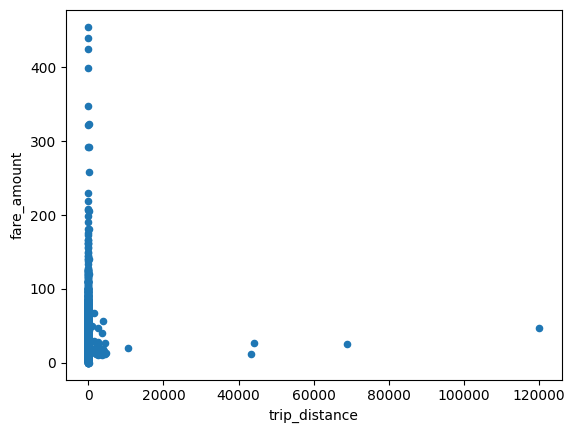

In [ ]:
df.plot.scatter(x='trip_distance', y='fare_amount')

Cek kembali apakah masih ada nilai 0 pada kolom tip_amount, passenger_count, trip_distance, fare_amount, dan total_amount.

In [ ]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if np.issubdtype(df[col].dtype, np.number) else 0 for col in df.columns]
}).round(3)

,feature,data_type,0_value(%)
0,lpep_pickup_datetime,object,0.000
1,lpep_dropoff_datetime,object,0.000
2,RatecodeID,float64,0.000
3,PULocationID,int64,0.000
4,DOLocationID,int64,0.000
5,trip_distance,float64,0.000
6,fare_amount,float64,0.000
7,tip_amount,float64,40.431
8,total_amount,float64,0.000
9,payment_type,float64,0.000


### Missing Values Handling

**a. Menampilkan data nilai null pada setiap kolom.**

In [ ]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value(%)': df.isna().mean().values * 100
}).round(3)

,feature,data_type,null_value(%)
0,lpep_pickup_datetime,object,0.000
1,lpep_dropoff_datetime,object,0.000
2,RatecodeID,float64,6.443
3,PULocationID,int64,0.000
4,DOLocationID,int64,0.000
5,trip_distance,float64,0.000
6,fare_amount,float64,0.000
7,tip_amount,float64,0.000
8,total_amount,float64,0.000
9,payment_type,float64,6.443


**b. Melakukan Handling Missing Values pada Kolom RatecodeID**

Penanganan Nilai Null pada kolom RatecodeID dengan mengisinya dengan nilai mediannya yaitu 1. Hal ini dengan pertimbangan karena kolom RatecodeID tidak terdistribusi dengan normal.

In [ ]:
df['RatecodeID'].fillna(1, inplace=True)

Selain terdapat nilai Null, pada kolom 'RatecodeID' terdapat nilai yaitu nilai 99. Padahal pada feature description nilai pada kolom 'RatecodeID' hanya terdiri dari angka 1, 2, 3, 4, 5, dan 6.

Penanganan Nilai 99 pada kolom RatecodeID dengan mengisinya dengan nilai mediannya yaitu 1. Hal ini dengan pertimbangan karena kolom RatecodeID tidak terdistribusi dengan normal.

In [ ]:
df['RatecodeID'] = df['RatecodeID'].replace(99, 1)

**c. Melakukan Handling Missing Values pada Kolom payment_type**

Berdasarkan description features main data dijelaskan bahwa tips diberikan hanya untuk metode pembayaran menggunakan kartu kredit akan terisi secara otomatis. Oleh karena itu, dapat disimpulkan jika tips > 0 maka metode yang digunakan adalah kartu kredit.

Cek argumentasi di atas berdasarkan dataset yang tersedia.

In [ ]:
df[(df['tip_amount']>0)]['payment_type'].value_counts().to_frame()

,count
payment_type,
1.0,34834
2.0,1


Setelah dilakukan pengecekan, terdapat satu baris yang error dimana harusnya semua tip_amount > 0 menggunakan payment_type 1 yaitu kartu kredit.

Lakukan perbaikan data pada baris yang error tersebut dengan mengisinya menggunakan nilai 1.

In [ ]:
df.loc[(df['tip_amount']>0) & (df['payment_type']==2), 'payment_type'] = 1

Lakukan pengisian nilai null pada kolom payment_type menggunakan nilai 1.

In [ ]:
df.loc[df['payment_type'].isna(), 'payment_type'] = df['tip_amount'].apply(lambda x: 1.0 if x > 0.0 else 5.0)

**d. Melakukan Handling Missing Values pada Kolom trip_type**

In [ ]:
# Correlation Calculation
df['trip_type'].corr(df['RatecodeID'], method='pearson')

0.9156725837161542

Berdasarkan perhitungan korelasi, trip_type sangat dipengaruhi oleh RatecodeID dengan nilai korelasi sebesar 0,9159. Artinya trip_type terhadap RatecodeID memiliki korelasi yang kuat.

Oleh karena itu, kita bisa mengisi nilai Null pada kolom trip_type berdasarkan nilai RatecodeID-nya.

In [ ]:
df.groupby(['RatecodeID', 'trip_type']).agg(total=('trip_type', 'count'))

total
RatecodeID trip_type       
1.0        1.0        59398
           2.0            2
2.0        1.0          131
3.0        1.0           20
4.0        1.0           51
           2.0            2
5.0        1.0          115
           2.0          840

Berdasarkan dataframe di atas, mayoritas RatecodeID 1.0 memiliki trip_type 1.0. Oleh karena itu, nilai null pada kolom trip_type yang memiliki nilai RatecodeID 1.0 bisa diisi 1.0.

In [ ]:
df[df['trip_type'].isna()].groupby('RatecodeID').agg(total=('RatecodeID', 'count'))

,total
RatecodeID,
1.0,4181


In [ ]:
df['trip_type'].fillna(1, inplace=True)

**e. Melakukan Handling Missing Values pada Kolom 'PUzone', 'PUborough',	'PUlongitude',	'PUlatitude', 'DOzone', 'DOborough', 'DOlongitude', dan 'DOlatitude'**

Pada kolom 'PUzone', 'PUborough',	'PUlongitude',	'PUlatitude', 'DOzone', 'DOborough', 'DOlongitude', dan 'DOlatitude' nilai Null terjadi karena keterbatasan supporting data. Pada kolom 'LocationID' supporting data tidak terdapat nilai 57, 264, dan 265 sehingga mengakibatkan nilai null pada saat proses merger data.

In [ ]:
location

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,1.023971e+06,266866.032718
259,260,0.133514,0.000422,Woodside,260,Queens,1.010063e+06,211298.529136
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,9.807446e+05,197628.272456
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,9.994435e+05,222247.381595


In [ ]:
df[df['PUzone'].isna()][['PULocationID',	'DOLocationID', 'PUzone', 'PUborough', 'DOzone', 'DOborough']]

,PULocationID,DOLocationID,PUzone,PUborough,DOzone,DOborough
1387,264,256,NaN,NaN,Williamsburg (South Side),Brooklyn
2346,265,265,NaN,NaN,NaN,NaN
3828,264,264,NaN,NaN,NaN,NaN
7038,265,82,NaN,NaN,Elmhurst,Queens
7964,264,264,NaN,NaN,NaN,NaN
8486,265,122,NaN,NaN,Hollis,Queens
9305,265,82,NaN,NaN,Elmhurst,Queens
9534,264,264,NaN,NaN,NaN,NaN
10887,265,265,NaN,NaN,NaN,NaN
11996,265,265,NaN,NaN,NaN,NaN


Hitung berapa persen jumlah baris mengandung nilai Null dari data keseluruhan.

In [ ]:
df_null_loc = df[df['PUzone'].isna()]

In [ ]:
print("Nilai Null :", df_null_loc.shape[0]/len(df)*100,"%")

Nilai Null : 0.08804448563484708 %


Nilai Null pada kolom 'PUzone', 'PUborough',	'PUlongitude',	'PUlatitude', 'DOzone', 'DOborough', 'DOlongitude', dan 'DOlatitude' jika ditotalkan hanya sebesar 0,0875% dari keseluruhan data. Artinya apabila dihapuskan tidak akan berdampak secara signifikan karena nilainya di bawah 5%.

In [ ]:
df.dropna(inplace=True)

Cek kembali apakah masih ada nilai Null pada setiap kolom.

In [ ]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value(%)': df.isna().mean().values * 100
}).round(3)

,feature,data_type,null_value(%)
0,lpep_pickup_datetime,object,0.0
1,lpep_dropoff_datetime,object,0.0
2,RatecodeID,float64,0.0
3,PULocationID,int64,0.0
4,DOLocationID,int64,0.0
5,trip_distance,float64,0.0
6,fare_amount,float64,0.0
7,tip_amount,float64,0.0
8,total_amount,float64,0.0
9,payment_type,float64,0.0


### Outliers Handling

**a. Outliers Handling Kolom lpep_pickup_datetime dan lpep_dropoff_datetime**

Melakukan formatting pada kolom berisi tanggal seperti 'lpep_pickup_datetime' dan 'lpep_dropoff_datetime'.

In [ ]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

Lakukan pengecekan rentang waktu untuk kedua kolom tersebut.

In [ ]:
df['lpep_pickup_datetime'].dt.month.value_counts().to_frame()

,count
lpep_pickup_datetime,
1,64372
12,2
2,1


In [ ]:
df['lpep_pickup_datetime'].dt.year.value_counts().to_frame()

,count
lpep_pickup_datetime,
2023,64372
2022,2
2009,1


Terdapat 4 baris yang merupakan outliers yaitu pada tahun 2022 dan 2009.

Hitung berapa persen jumlah outliers berdasarkan data keseluruhan.

In [ ]:
outliers_datetime = df[(df['lpep_pickup_datetime'].dt.month!=1) | (df['lpep_pickup_datetime'].dt.year!=2023)]

outliers_datetime

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough
319,2022-12-09 14:10:49,2022-12-09 14:22:26,1.0,7,56,5.37,16.0,0.00,16.80,2.0,1.0,Astoria,Queens,Corona,Queens
342,2022-12-09 14:55:42,2022-12-09 15:33:06,1.0,260,164,5.48,25.5,0.00,35.60,2.0,1.0,Woodside,Queens,Midtown South,Manhattan
18291,2009-01-01 20:21:27,2009-01-02 11:07:31,1.0,65,178,7.72,34.5,7.20,43.20,1.0,1.0,Downtown Brooklyn/MetroTech,Brooklyn,Ocean Parkway South,Brooklyn
25667,2023-02-01 03:10:05,2023-02-01 03:40:35,5.0,82,198,4.58,28.0,5.66,33.96,1.0,2.0,Elmhurst,Queens,Ridgewood,Queens


In [ ]:
print("Nilai Outliers Datetime :", outliers_datetime.shape[0]/len(df)*100,"%")

Nilai Outliers Datetime : 0.006213592233009709 %


Nilai Outliers pada kolom 'lpep_pickup_datetime' dan 'lpep_dropoff_datetime' jika ditotalkan hanya sebesar 0,0077% dari keseluruhan data. Artinya apabila dihapuskan tidak akan berdampak secara signifikan karena nilainya di bawah 5%.

In [ ]:
df.drop(outliers_datetime.index, inplace=True)

**b. Outliers Handling Kolom fare_amount**

Referensi: https://www.nyc.gov/site/tlc/passengers/taxi-fare.page

Terdapat fare_amount yang tidak sesuai dengan regulasi. Pada regulasi initial charge adalah sebesar $3.00 .

Oleh karena itu, fare_amount dengan < $3.00 bisa didrop.

In [ ]:
df[['trip_distance', 'fare_amount']].sort_values(by='fare_amount', ascending=True)[df['fare_amount'] < 3]

,trip_distance,fare_amount
29125,5.80,0.01
52859,3.30,0.01
25138,8.31,0.05
48898,0.01,0.15
44662,1.34,0.15
22270,0.03,0.30
34616,0.04,0.45
37145,1.40,1.50
2676,0.06,2.50
20929,1.70,2.50


In [ ]:
outliers_fare = df[df['fare_amount'] < 3]

In [ ]:
print("Nilai Outliers fare_amount:", outliers_fare.shape[0]/len(df)*100,"%")

Nilai Outliers fare_amount: 0.03262338630749872 %


Nilai Outliers pada kolom 'fare_amount' jika ditotalkan hanya sebesar 0,0324% dari keseluruhan data. Artinya apabila dihapuskan tidak akan berdampak secara signifikan karena nilainya di bawah 5%.

In [ ]:
df.drop(outliers_fare.index, inplace=True)

Selain itu, ada beberapa data dengan 'RatecodeID' bernilai 2 atau Rate #2- JFK Airport. Pada regulasi fare_amount untuk Rate #2- JFK Airport adalah flat sebesar $70.

In [ ]:
outliers_fare2 = df[(df['RatecodeID'] == 2) & (df['fare_amount'] != 70)]

outliers_fare2

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough
12748,2023-01-07 14:32:13,2023-01-07 14:32:17,2.0,166,166,0.04,52.0,0.0,52.80,2.0,1.0,Morningside Heights,Manhattan,Morningside Heights,Manhattan
29335,2023-01-15 05:24:00,2023-01-15 05:56:35,2.0,120,132,20.60,52.0,0.0,59.35,2.0,1.0,Highbridge Park,Manhattan,JFK Airport,Queens


In [ ]:
print("Nilai Outliers fare_amount:", outliers_fare2.shape[0]/len(df)*100,"%")

Nilai Outliers fare_amount: 0.003108003108003108 %


Nilai Outliers pada kolom 'fare_amount' jika ditotalkan hanya sebesar 0,00308% dari keseluruhan data. Artinya apabila dihapuskan tidak akan berdampak secara signifikan karena nilainya di bawah 5%.



In [ ]:
df.drop(outliers_fare2.index, inplace=True)

**c. Outliers Handling Kolom trip_distance**

**Menghitung berapa detik setelah supir taxi menjemput dan menurunkan penumpang. Dengan asumsi hanya bernilai < 60 detik bisa diartikan trip di-cancel oleh penumpang.**

In [ ]:
trip_duration = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds()

outliers_distance = df[trip_duration < 60]

outliers_distance

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough
35,2023-01-01 00:41:53,2023-01-01 00:41:58,1.0,83,83,6.70,3.0,0.00,5.50,3.0,1.0,Elmhurst/Maspeth,Queens,Elmhurst/Maspeth,Queens
104,2023-01-01 01:11:01,2023-01-01 01:11:06,5.0,179,179,0.01,190.0,0.00,191.00,2.0,2.0,Old Astoria,Queens,Old Astoria,Queens
146,2023-01-01 02:03:52,2023-01-01 02:03:57,1.0,169,169,0.01,3.0,0.00,5.50,2.0,1.0,Mount Hope,Bronx,Mount Hope,Bronx
166,2023-01-01 01:59:48,2023-01-01 01:59:51,5.0,36,36,0.09,100.0,20.06,120.36,1.0,2.0,Bushwick North,Brooklyn,Bushwick North,Brooklyn
201,2023-01-01 03:00:27,2023-01-01 03:00:54,3.0,251,251,4.90,23.0,0.00,31.55,2.0,1.0,Westerleigh,Staten Island,Westerleigh,Staten Island
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64708,2023-01-31 18:39:16,2023-01-31 18:39:29,1.0,130,130,0.05,3.0,0.00,7.00,4.0,1.0,Jamaica,Queens,Jamaica,Queens
64836,2023-01-31 19:17:15,2023-01-31 19:17:24,1.0,7,7,5.90,3.0,0.00,7.00,1.0,1.0,Astoria,Queens,Astoria,Queens
64894,2023-01-31 19:06:18,2023-01-31 19:06:46,1.0,75,75,0.08,3.0,0.00,7.00,3.0,1.0,East Harlem South,Manhattan,East Harlem South,Manhattan
65160,2023-01-31 22:03:44,2023-01-31 22:03:56,5.0,74,74,7.84,50.0,0.00,51.00,1.0,2.0,East Harlem North,Manhattan,East Harlem North,Manhattan


In [ ]:
print("Nilai Outliers trip_distance:", outliers_distance.shape[0]/len(df)*100,"%")

Nilai Outliers trip_distance: 0.6511468887921925 %


Nilai Outliers pada kolom 'trip_distance' jika ditotalkan hanya sebesar 0,651% dari keseluruhan data. Artinya apabila dihapuskan tidak akan berdampak secara signifikan karena nilainya di bawah 5%.

In [ ]:
df.drop(outliers_distance.index, inplace=True)

Referensi : https://www.nyc.gov/site/tlc/passengers/taxi-fare.page

**Pada regulasi initial charge adalah sebesar $3.00**

**dan akan bertambah sebesar $0.7 setiap 0.2 miles.**

**Artinya trip dengan trip_distance < 0.2 miles dan dengan fare_amount diatas $3.00 artinya data tersebut outliers.**

In [ ]:
outliers_distance2 = df[(df['trip_distance'] < 0.2) & (df['fare_amount'] > 3.00)]

outliers_distance2

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough
214,2023-01-01 03:49:01,2023-01-01 03:50:37,5.0,157,157,0.03,50.00,0.00,50.30,1.0,2.0,Maspeth,Queens,Maspeth,Queens
763,2023-01-01 15:55:38,2023-01-01 15:56:38,1.0,41,41,0.11,3.70,0.00,5.20,2.0,1.0,Central Harlem,Manhattan,Central Harlem,Manhattan
835,2023-01-01 16:53:45,2023-01-01 16:54:56,1.0,74,74,0.08,3.70,0.00,5.20,2.0,1.0,East Harlem North,Manhattan,East Harlem North,Manhattan
862,2023-01-01 16:58:48,2023-01-01 17:05:43,1.0,82,83,0.16,7.20,0.00,8.70,2.0,1.0,Elmhurst,Queens,Elmhurst/Maspeth,Queens
945,2023-01-01 17:20:29,2023-01-01 17:21:33,1.0,74,74,0.01,3.70,0.00,5.20,2.0,1.0,East Harlem North,Manhattan,East Harlem North,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67420,2023-01-17 05:25:00,2023-01-17 05:27:00,1.0,55,55,0.06,80.04,16.21,97.25,1.0,1.0,Coney Island,Brooklyn,Coney Island,Brooklyn
67644,2023-01-18 16:41:00,2023-01-18 16:44:00,1.0,11,11,0.01,48.19,0.92,50.11,1.0,1.0,Bath Beach,Brooklyn,Bath Beach,Brooklyn
68751,2023-01-25 17:30:00,2023-01-25 17:31:00,1.0,82,82,0.09,20.35,1.58,22.93,1.0,1.0,Elmhurst,Queens,Elmhurst,Queens
68858,2023-01-26 12:09:00,2023-01-26 12:10:00,1.0,17,225,0.02,25.81,7.71,34.52,1.0,1.0,Bedford,Brooklyn,Stuyvesant Heights,Brooklyn


In [ ]:
print("Nilai Outliers trip_distance:", outliers_distance2.shape[0]/len(df)*100,"%")

Nilai Outliers trip_distance: 0.3503887124779052 %


Nilai Outliers pada kolom 'trip_distance' jika ditotalkan hanya sebesar 0,348% dari keseluruhan data. Artinya apabila dihapuskan tidak akan berdampak secara signifikan karena nilainya di bawah 5%.

In [ ]:
df.drop(outliers_distance2.index, inplace=True)

**Referensi**: https://en.wikipedia.org/wiki/Taxis_of_New_York_City

**Berdasarkan data seorang supir taxi NYC rata-rata menempuh jarak sebesar 180 miles per shift. Artinya apabila ada satu trip dengan jarak lebih dari 180 miles bisa disebut dengan outlier.**

In [ ]:
outliers_distance3 = df[(df['trip_distance'] > 180)]

outliers_distance3

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough
34117,2023-01-17 18:40:38,2023-01-17 19:04:45,5.0,82,236,1571.97,29.97,3.04,43.31,1.0,1.0,Elmhurst,Queens,Upper East Side North,Manhattan
65348,2023-01-01 12:35:00,2023-01-01 12:58:00,1.0,181,137,579.63,28.49,4.84,37.08,1.0,1.0,Park Slope,Brooklyn,Kips Bay,Manhattan
65799,2023-01-05 08:39:00,2023-01-05 08:58:00,1.0,193,140,2555.47,23.68,0.49,27.92,1.0,1.0,Queensbridge/Ravenswood,Queens,Lenox Hill East,Manhattan
65911,2023-01-05 17:21:00,2023-01-05 17:26:00,1.0,49,65,3077.89,12.02,4.00,17.02,1.0,1.0,Clinton Hill,Brooklyn,Downtown Brooklyn/MetroTech,Brooklyn
65925,2023-01-05 18:07:00,2023-01-05 18:13:00,1.0,193,193,2606.52,11.00,1.20,13.20,1.0,1.0,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens
65962,2023-01-06 07:27:00,2023-01-06 07:30:00,1.0,41,74,43392.12,12.02,2.60,15.62,1.0,1.0,Central Harlem,Manhattan,East Harlem North,Manhattan
66306,2023-01-08 23:47:00,2023-01-08 23:59:00,1.0,52,79,2446.53,23.89,4.34,31.98,1.0,1.0,Cobble Hill,Brooklyn,East Village,Manhattan
66313,2023-01-09 04:28:00,2023-01-09 04:46:00,1.0,119,20,2027.31,20.64,1.00,22.64,1.0,1.0,Highbridge,Bronx,Belmont,Bronx
66508,2023-01-10 15:40:00,2023-01-10 16:24:00,1.0,26,37,1082.45,49.80,0.95,51.75,1.0,1.0,Borough Park,Brooklyn,Bushwick South,Brooklyn
66553,2023-01-11 06:02:00,2023-01-11 06:32:00,1.0,69,90,120098.84,46.82,2.00,52.57,1.0,1.0,East Concourse/Concourse Village,Bronx,Flatiron,Manhattan


In [ ]:
print("Nilai Outliers trip_distance:", outliers_distance3.shape[0]/len(df)*100,"%")

Nilai Outliers trip_distance: 0.05651047798445962 %


Nilai Outliers pada kolom 'trip_distance' jika ditotalkan hanya sebesar 0,0561% dari keseluruhan data. Artinya apabila dihapuskan tidak akan berdampak secara signifikan karena nilainya di bawah 5%.

In [ ]:
df.drop(outliers_distance3.index, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63669 entries, 0 to 69599
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   lpep_pickup_datetime   63669 non-null  datetime64[ns]
 1   lpep_dropoff_datetime  63669 non-null  datetime64[ns]
 2   RatecodeID             63669 non-null  float64       
 3   PULocationID           63669 non-null  int64         
 4   DOLocationID           63669 non-null  int64         
 5   trip_distance          63669 non-null  float64       
 6   fare_amount            63669 non-null  float64       
 7   tip_amount             63669 non-null  float64       
 8   total_amount           63669 non-null  float64       
 9   payment_type           63669 non-null  float64       
 10  trip_type              63669 non-null  float64       
 11  PUzone                 63669 non-null  object        
 12  PUborough              63669 non-null  object        
 13  DOzone

## 7. Pre-Processing Data

## RatecodeID

Mengubah nilai 1, 2, 3, 4, 5, dan 6 menjadi 'Standard rate', 'JFK Airport', 'Newark Airport', 'Nassau or Westchester', 'Negotiated fare', dan 'Group ride'.

In [ ]:
df['Rate'] = df['RatecodeID'].replace({1:'Standard Rate', 2:'JFK Airport', 3:'Newark Airport', 4:'Nassau or Westchester', 5:'Negotiated Fare', 6:'Group Ride'})
df['Rate'].value_counts()

Rate
Standard Rate            62848
Negotiated Fare            694
JFK Airport                115
Newark Airport               9
Nassau or Westchester        3
Name: count, dtype: int64

### Payment Types

In [ ]:
df['payment_type']=df['payment_type'].replace({1:'Credit card', 2:'Cash', 3:'No charge', 4:'Dispute', 5:'Unknown', 6:'Voided trip'})
df['payment_type'].value_counts()

payment_type
Credit card    41730
Cash           21336
Unknown          430
No charge        143
Dispute           30
Name: count, dtype: int64

### Trip Type

In [ ]:
df['trip_type']=df['trip_type'].replace({1:'Street-hail', 2:'Dispatch'})
df['trip_type'].value_counts()

trip_type
Street-hail    63068
Dispatch         601
Name: count, dtype: int64

### Feature Creation - Trip Duration

In [ ]:
df['trip_duration'] = (trip_duration/60).round(2)

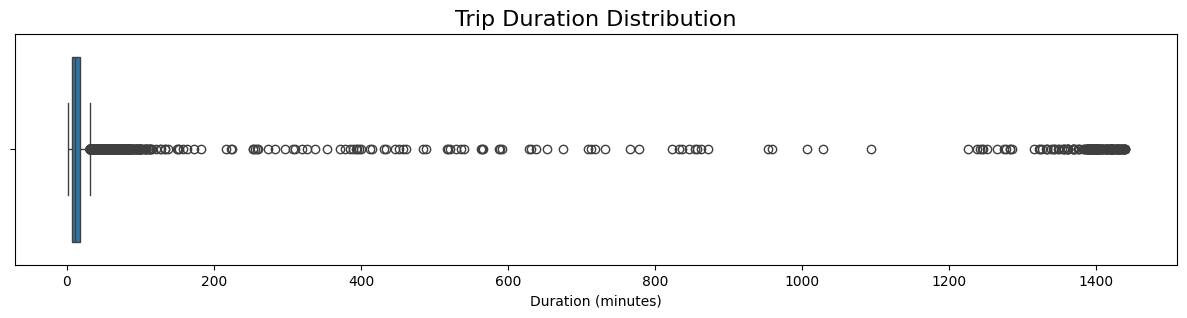

In [ ]:
plt.figure(figsize=(15, 3))


sns.boxplot(data=df, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distribution', fontsize=16)

plt.show()

### Feature Creation - Trip Duration Bins

Untuk mengatasi outlier dari trip_duration maka dilakukan pengumpulan (bins) untuk beberapa segment duration (minutes).

In [ ]:
bins_of_duration = [0, 10, 20, 30, 40, 50, np.inf]
labels_of_duration = ['<10 minutes', '11-20 minutes', '21-30 minutes', '31-40 minutes', '41-50 minutes', '>50 minutes']

df['trip_duration_bins'] = pd.cut(df['trip_duration'], bins=bins_of_duration, labels=labels_of_duration)

In [ ]:
df['trip_duration_bins'].value_counts()

trip_duration_bins
<10 minutes      26196
11-20 minutes    25936
21-30 minutes     7671
31-40 minutes     2311
>50 minutes        787
41-50 minutes      768
Name: count, dtype: int64

### Feature Creation - Driving Speed

In [ ]:
df['speed'] = (df['trip_distance'] / (df['trip_duration']/60)).round(2)

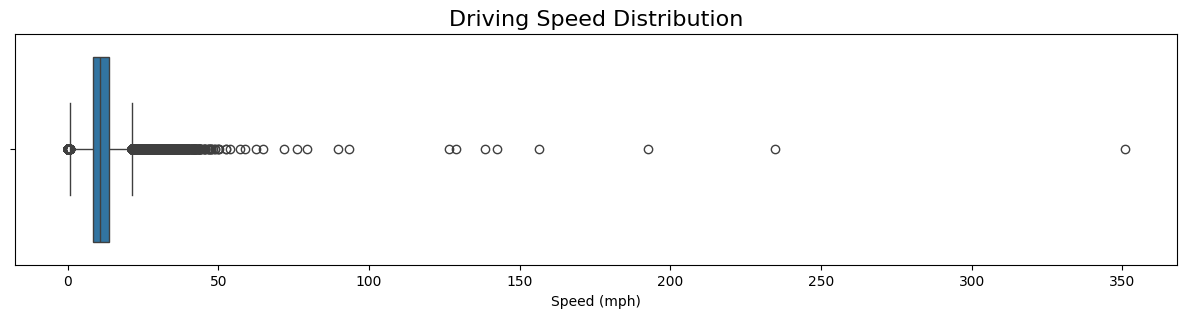

In [ ]:
plt.figure(figsize=(15, 3))


sns.boxplot(data=df, x='speed')
plt.xlabel('Speed (mph)')
plt.title('Driving Speed Distribution', fontsize=16)

plt.show()

Referensi: https://ekjlaw.com/speed-limits-in-new-york-how-much-over-the-speed-limit-is-too-much/

 New York City memberlakukan speed limit demi keamanan pengguna jalan. Speed Limit ini berdasarkan hal berikut:

1. Residential Areas: 30 MPH.
2. School Zones: < 20 MPH selama jam sekolah.
3. Highways: maximum limits antara 55 sampai 65 MPH.
4. Dalam kota NYC: 30 MPH

Oleh karena itu, speed yang melebihi 65 MPH bisa disebut outliers.

In [ ]:
outliers_speed = df[df['speed'] > 65]

outliers_speed

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,PUzone,PUborough,DOzone,DOborough,Rate,trip_duration,trip_duration_bins,speed
3097,2023-01-03 08:07:04,2023-01-03 08:12:12,1.0,74,263,6.50,26.10,0.00,30.35,No charge,Street-hail,East Harlem North,Manhattan,Yorkville West,Manhattan,Standard Rate,5.13,<10 minutes,76.02
10119,2023-01-06 11:56:30,2023-01-06 11:57:40,1.0,75,75,1.40,3.70,0.00,5.20,No charge,Street-hail,East Harlem South,Manhattan,East Harlem South,Manhattan,Standard Rate,1.17,<10 minutes,71.79
29001,2023-01-14 22:51:55,2023-01-14 22:55:09,1.0,74,14,18.88,74.40,15.93,95.58,Credit card,Street-hail,East Harlem North,Manhattan,Bay Ridge,Brooklyn,Standard Rate,3.23,<10 minutes,350.71
38485,2023-01-19 17:40:43,2023-01-19 17:41:47,1.0,116,116,2.30,3.00,0.00,5.50,Cash,Street-hail,Hamilton Heights,Manhattan,Hamilton Heights,Manhattan,Standard Rate,1.07,<10 minutes,128.97
41293,2023-01-20 21:34:43,2023-01-20 21:35:47,1.0,66,66,1.60,3.70,0.00,6.20,No charge,Street-hail,DUMBO/Vinegar Hill,Brooklyn,DUMBO/Vinegar Hill,Brooklyn,Standard Rate,1.07,<10 minutes,89.72
49687,2023-01-24 20:54:42,2023-01-24 20:55:58,5.0,216,216,1.68,25.00,0.00,26.00,Credit card,Dispatch,South Ozone Park,Queens,South Ozone Park,Queens,Negotiated Fare,1.27,<10 minutes,79.37
66051,2023-01-06 14:16:00,2023-01-06 14:59:00,1.0,82,130,137.95,44.90,4.04,49.94,Credit card,Street-hail,Elmhurst,Queens,Jamaica,Queens,Standard Rate,43.00,41-50 minutes,192.49
66104,2023-01-06 23:02:00,2023-01-06 23:12:00,1.0,41,116,23.77,14.63,3.13,18.76,Credit card,Street-hail,Central Harlem,Manhattan,Hamilton Heights,Manhattan,Standard Rate,10.00,<10 minutes,142.62
66110,2023-01-07 01:47:00,2023-01-07 01:58:00,1.0,129,179,25.40,19.30,3.04,23.34,Credit card,Street-hail,Jackson Heights,Queens,Old Astoria,Queens,Standard Rate,11.00,11-20 minutes,138.55
66117,2023-01-07 03:52:00,2023-01-07 03:53:00,1.0,256,256,3.91,18.58,3.92,23.50,Credit card,Street-hail,Williamsburg (South Side),Brooklyn,Williamsburg (South Side),Brooklyn,Standard Rate,1.00,<10 minutes,234.60


In [ ]:
print("Nilai Outliers speed:", outliers_speed.shape[0]/len(df)*100,"%")

Nilai Outliers speed: 0.020418099860214547 %


Nilai Outliers pada kolom 'speed' jika ditotalkan hanya sebesar 0,020% dari keseluruhan data. Artinya apabila dihapuskan tidak akan berdampak secara signifikan karena nilainya di bawah 5%.

In [ ]:
df.drop(outliers_speed.index, inplace=True)

### Feature Creation - Bins

Pembuatan Bins diperuntukan untuk mempermudah proses analisis dengan mengelompokkan data menjadi beberapa kelompok sesuai range tertentu agar menjadi kategorikal kolom.

### Feature Creation - Time Bins

In [ ]:
time_bins = [0, 5, 11, 15, 20, 24]
time_labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Night']
df['pickup_time_category'] = pd.cut(df['lpep_pickup_datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False)

<Figure size 1500x1500 with 0 Axes>

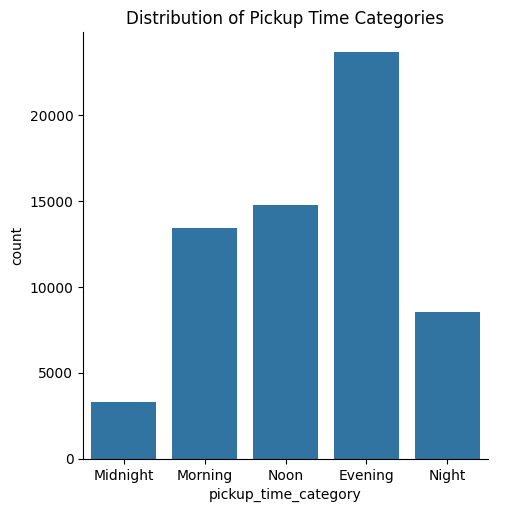

In [ ]:
plt.figure(figsize=(15, 15))

sns.catplot(x="pickup_time_category", kind="count", data=df)

plt.title("Distribution of Pickup Time Categories")

plt.show()

### Feature Creation - Day Bins

In [ ]:
df['day_category'] = df['lpep_pickup_datetime'].dt.day_name().apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

<Figure size 1500x1500 with 0 Axes>

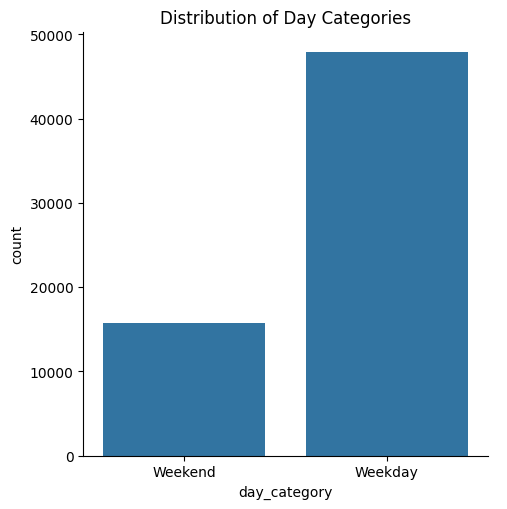

In [ ]:
plt.figure(figsize=(15, 15))

sns.catplot(x="day_category", kind="count", data=df)

plt.title("Distribution of Day Categories")

plt.show()

### Feature Creation - Driving Speed Bins

In [ ]:
bins_of_speed = [0, 10, 20, 30, 40, 50, np.inf]
labels_of_speed = ['<10 mph', '11-20 mph', '21-30 mph', '31-40 mph', '41-50 mph', '>50 mph' ]
df['speed_bins'] = pd.cut(df['speed'], bins=bins_of_speed, labels=labels_of_speed)

<Figure size 2000x2000 with 0 Axes>

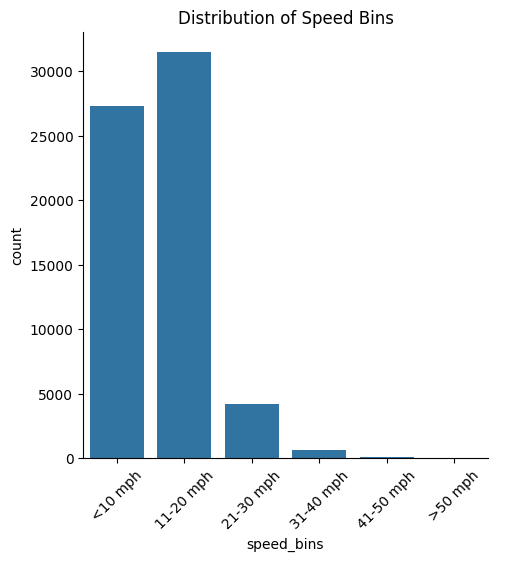

In [ ]:
plt.figure(figsize=(20, 20))

sns.catplot(x="speed_bins", kind="count", data=df)

plt.title("Distribution of Speed Bins")

plt.xticks(rotation=45)

plt.show()

### Feature Creation - Distances Bins

In [ ]:
bins_of_distance = [0, 10, 20, 30, np.inf]
labels_of_distance = ['<10 miles','11-20 miles','21-30 miles', '>30 miles']

df['trip_distance_bins'] = pd.cut(df['trip_distance'], bins=bins_of_distance, labels=labels_of_distance)

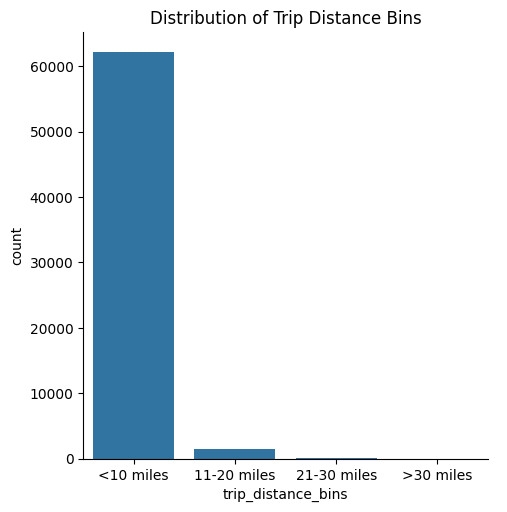

In [ ]:
sns.catplot(x="trip_distance_bins", kind="count", data=df)

plt.title("Distribution of Trip Distance Bins")

plt.show()

### Feature Creation - Fare Amount Bins

In [ ]:
bins_fare = [0, 20, 40, 60, 80, np.inf]
labels_fare = ['<20$', '21-40$', '41-60$', '61-80$', '>80$']
df['fare_amount_bins'] = pd.cut(df['fare_amount'], bins=bins_fare, labels=labels_fare)

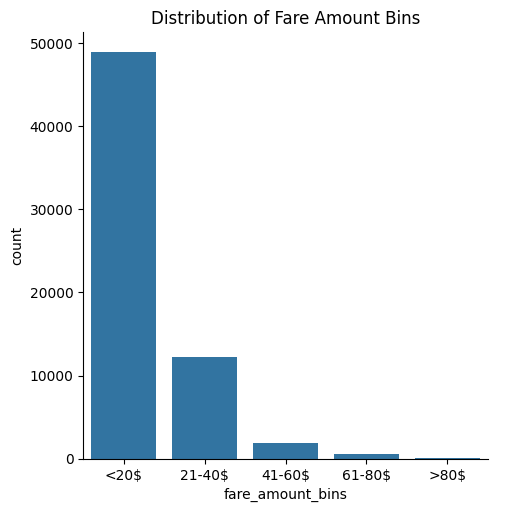

In [ ]:
sns.catplot(x="fare_amount_bins", kind="count", data=df)

plt.title("Distribution of Fare Amount Bins")

plt.show()

### Feature Creation - Tips Amount Bins

In [ ]:
bins_tip = [-np.inf, 0, 10, 20, 30, np.inf]
labels_tip = ['0$', '1-10$', '11-20$', '21-30$', '>30$']
df['tip_amount_bins'] = pd.cut(df['tip_amount'], bins=bins_tip, labels=labels_tip)

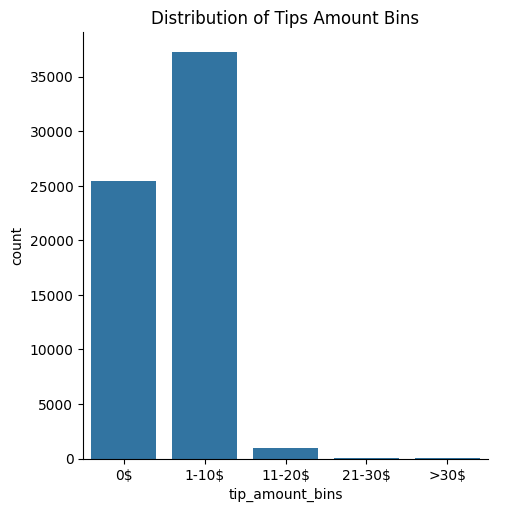

In [ ]:
sns.catplot(x="tip_amount_bins", kind="count", data=df)

plt.title("Distribution of Tips Amount Bins")

plt.show()

### Feature Creation - Total Amount Bins

In [ ]:
bins_total = [0, 10, 20, 30, 40, 50, np.inf]
labels_total = ['1-10$', '11-20$', '21-30$', '31-40$', '41-50$', '>50$' ]
df['total_amount_bins'] = pd.cut(df['total_amount'], bins=bins_total, labels=labels_total)

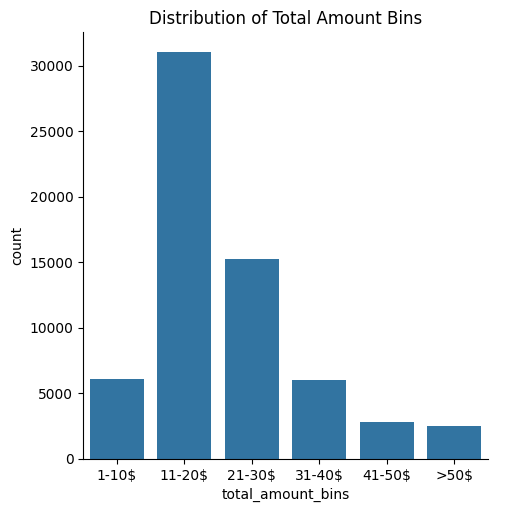

In [ ]:
sns.catplot(x="total_amount_bins", kind="count", data=df)

plt.title("Distribution of Total Amount Bins")

plt.show()

## Drop Column

Drop kolom yang sudah tidak akan digunakan kembali.

In [ ]:
df = df.drop(['RatecodeID',
         'PULocationID',
         'DOLocationID'], axis=1)

## Setting Column Index

Mengubah urutan kolom agar mempermudah proses analisis.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63656 entries, 0 to 69599
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   lpep_pickup_datetime   63656 non-null  datetime64[ns]
 1   lpep_dropoff_datetime  63656 non-null  datetime64[ns]
 2   trip_distance          63656 non-null  float64       
 3   fare_amount            63656 non-null  float64       
 4   tip_amount             63656 non-null  float64       
 5   total_amount           63656 non-null  float64       
 6   payment_type           63656 non-null  object        
 7   trip_type              63656 non-null  object        
 8   PUzone                 63656 non-null  object        
 9   PUborough              63656 non-null  object        
 10  DOzone                 63656 non-null  object        
 11  DOborough              63656 non-null  object        
 12  Rate                   63656 non-null  object        
 13  trip_d

In [ ]:
 df = df[['lpep_pickup_datetime',
             'lpep_dropoff_datetime',
             'day_category',
             'pickup_time_category',
             'Rate',
             'PUborough',
             'PUzone',
             'DOborough',
             'DOzone',
             'trip_distance',
             'trip_distance_bins',
             'fare_amount',
             'fare_amount_bins',
             'total_amount',
             'total_amount_bins',
             'tip_amount',
             'tip_amount_bins',
             'payment_type',
             'trip_type',
             'trip_duration',
             'trip_duration_bins',
             'speed',
             'speed_bins']]

In [ ]:
df.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,day_category,pickup_time_category,Rate,PUborough,PUzone,DOborough,DOzone,trip_distance,...,total_amount,total_amount_bins,tip_amount,tip_amount_bins,payment_type,trip_type,trip_duration,trip_duration_bins,speed,speed_bins
0,2023-01-01 00:26:10,2023-01-01 00:37:11,Weekend,Midnight,Standard Rate,Manhattan,Morningside Heights,Manhattan,Lincoln Square West,2.58,...,24.18,21-30$,4.03,1-10$,Credit card,Street-hail,11.02,11-20 minutes,14.05,11-20 mph
1,2023-01-01 00:51:03,2023-01-01 00:57:49,Weekend,Midnight,Standard Rate,Manhattan,Bloomingdale,Manhattan,Central Park,1.81,...,15.84,11-20$,2.64,1-10$,Credit card,Street-hail,6.77,<10 minutes,16.04,11-20 mph
3,2023-01-01 00:13:14,2023-01-01 00:19:03,Weekend,Midnight,Standard Rate,Manhattan,Central Harlem,Manhattan,Upper West Side North,1.30,...,10.20,11-20$,1.70,1-10$,Credit card,Street-hail,5.82,<10 minutes,13.40,11-20 mph
4,2023-01-01 00:33:04,2023-01-01 00:39:02,Weekend,Midnight,Standard Rate,Manhattan,Central Harlem,Manhattan,East Harlem North,1.10,...,8.00,1-10$,0.00,0$,Credit card,Street-hail,5.97,<10 minutes,11.06,11-20 mph
5,2023-01-01 00:53:31,2023-01-01 01:11:04,Weekend,Midnight,Standard Rate,Manhattan,Central Harlem,Manhattan,Yorkville East,2.78,...,22.95,21-30$,0.00,0$,Cash,Street-hail,17.55,11-20 minutes,9.50,<10 mph


## Save Cleaned Dataset

In [ ]:
df.to_csv(r'NYC TLC Trip Record - Cleaned.csv', index= False)